# Introduction
This repository contains the codebase for an advanced video analysis pipeline that combines the power of multiple state-of-the-art models and methodologies including YOLO V8, ByteTrack, Movenet, and Transformer encoders for high-accuracy activity recognition. The pipeline is trained on the Actitracker dataset provided by the WISDM Lab.



In [1]:
!nvidia-smi

Sat Jul 15 04:19:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Connect Drive**

In [2]:
import os
import sys
from google.colab import drive
drive.mount('/content/drive/')

# Set the working directory for the tasks
SKELETON_DIR = '/content/drive/MyDrive/ActivityRecognition'
os.chdir(SKELETON_DIR)

package_path = '/content/packages'
os.symlink('/content/drive/MyDrive/ActivityRecognition/packages', package_path)
sys.path.insert(0, package_path)

Mounted at /content/drive/




# Install Dependencies

In [3]:
!pip install -q torch
!pip install -q torchvision
!pip install -q opencv-python-headless
!pip install -q tensorflow
!pip install -q tensorflow-gpu==2.4.1
!pip install -q opencv-python
!pip install -q matplotlib

!pip install -q imageioa
!pip install -q opencv-python
!pip install -q git+https://github.com/tensorflow/docs

!pip install -q pafy youtube-dl moviepy

!pip install -q git+https://github.com/huggingface/transformers

!pip install -q imageio[ffmpeg]
!pip install -q imageio-ffmpeg

# YOLO V5
%cd /content/drive/MyDrive/ActivityRecognition/packages/yolov5
!pip install -q -r requirements.txt

# YOLO V8
%cd /content/drive/MyDrive/ActivityRecognition/packages/ultralytics
!pip install -q -r requirements.txt

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.4.1 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==2.4.1
ERROR: Could not find a version that satisfies the requirement imageioa (from versions: none)
ERROR: No matching distribution found for imageioa
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 50.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.

In [4]:
%cd /content/drive/MyDrive/ActivityRecognition

/content/drive/MyDrive/ActivityRecognition


#  Import Dependencies

In [5]:
import cv2
import datetime as dt
import imageio
import imageio
import imageio_ffmpeg as ffmpeg
import math
import os
import pafy
import pandas as pd
import pdb
import pickle
import random
import seaborn as sns
import torch
import warnings

import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import numpy as np
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA


from collections import deque

from google.colab.patches import cv2_imshow
from IPython.display import HTML, display, clear_output
from tensorflow_docs.vis import embed
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from transformers import ViTModel, ViTConfig
from PIL import Image


import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

import ultralytics
ultralytics.checks()

from ultralytics import YOLO

warnings.filterwarnings('ignore')
%matplotlib inline

Ultralytics YOLOv8.0.135 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 24.4/78.2 GB disk)


**Movenet Helper Functions + Cropping Algorithm**



In [6]:
model_name = "movenet_lightning"

if "tflite" in model_name:
  if "movenet_lightning_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/float16/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
    input_size = 256
  elif "movenet_lightning_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/int8/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/int8/4?lite-format=tflite
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_path="model.tflite")
  interpreter.allocate_tensors()

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    # TF Lite format expects tensor type of uint8.
    input_image = tf.cast(input_image, dtype=tf.uint8)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    # Invoke inference.
    interpreter.invoke()
    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores

else:
  if "movenet_lightning" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    input_size = 192
  elif "movenet_thunder" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores

# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):

  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors

def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):

  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))

  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)

  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
  plt.margins(0,0)
  ax.xaxis.set_major_locator(plt.NullLocator())
  ax.yaxis.set_major_locator(plt.NullLocator())

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)

  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)

  return image_from_plot


def to_gif(images, duration):
    """Converts image sequence (4D numpy array) to gif."""
    # convert to RGB and save as GIF
    images_rgb = [Image.fromarray(np.array(img).astype(np.uint8)).convert("RGBA") for img in images]
    images_palette = [img.quantize().convert("RGBA") for img in images_rgb]
    imageio.mimsave('animation.gif', images_palette, duration=duration)
    return embed.embed_file('animation.gif')


def convert_gif_to_mp4(gif_path, output_path, fps=30):
    # Create reader object for the gif
    reader = imageio.get_reader(gif_path)
    # Get gif height, width, _ (channels)
    height, width, _ = reader.get_data(0).shape
    # Define the codec and create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Be sure to use lower case
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    # Write frames to video file
    for i, im in enumerate(reader):
        frame = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
        out.write(frame) # Write out frame to video
    # Release the VideoWriter
    out.release()


def to_mp4(image_sequence, output_path, fps=10):
    """
    Convert a sequence of images to MP4 video file.

    Parameters:
    image_sequence (list of ndarray): List of images.
    output_path (str): Path to the output MP4 file.
    fps (int, optional): Frames per second. Default is 30.
    """

    # Get size from the first image
    height, width, layers = image_sequence[0].shape

    # Define the codec and create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Be sure to use lower case
    video = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    # Iterate through image_sequence and add frames to video
    for image in image_sequence:
        video.write(image)

    # Release everything when job is finished
    video.release()
    cv2.destroyAllWindows()


def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))

# Cropping Algorithm
# Confidence score to determine whether a keypoint prediction is reliable.
MIN_CROP_KEYPOINT_SCORE = 0.2

def init_crop_region(image_height, image_width):
  if image_width > image_height:
    box_height = image_width / image_height
    box_width = 1.0
    y_min = (image_height / 2 - image_width / 2) / image_height
    x_min = 0.0
  else:
    box_height = 1.0
    box_width = image_height / image_width
    y_min = 0.0
    x_min = (image_width / 2 - image_height / 2) / image_width

  return {
    'y_min': y_min,
    'x_min': x_min,
    'y_max': y_min + box_height,
    'x_max': x_min + box_width,
    'height': box_height,
    'width': box_width
  }

def torso_visible(keypoints):
  return ((keypoints[0, 0, KEYPOINT_DICT['left_hip'], 2] >
           MIN_CROP_KEYPOINT_SCORE or
          keypoints[0, 0, KEYPOINT_DICT['right_hip'], 2] >
           MIN_CROP_KEYPOINT_SCORE) and
          (keypoints[0, 0, KEYPOINT_DICT['left_shoulder'], 2] >
           MIN_CROP_KEYPOINT_SCORE or
          keypoints[0, 0, KEYPOINT_DICT['right_shoulder'], 2] >
           MIN_CROP_KEYPOINT_SCORE))

def determine_torso_and_body_range(
    keypoints, target_keypoints, center_y, center_x):
  torso_joints = ['left_shoulder', 'right_shoulder', 'left_hip', 'right_hip']
  max_torso_yrange = 0.0
  max_torso_xrange = 0.0
  for joint in torso_joints:
    dist_y = abs(center_y - target_keypoints[joint][0])
    dist_x = abs(center_x - target_keypoints[joint][1])
    if dist_y > max_torso_yrange:
      max_torso_yrange = dist_y
    if dist_x > max_torso_xrange:
      max_torso_xrange = dist_x

  max_body_yrange = 0.0
  max_body_xrange = 0.0
  for joint in KEYPOINT_DICT.keys():
    if keypoints[0, 0, KEYPOINT_DICT[joint], 2] < MIN_CROP_KEYPOINT_SCORE:
      continue
    dist_y = abs(center_y - target_keypoints[joint][0]);
    dist_x = abs(center_x - target_keypoints[joint][1]);
    if dist_y > max_body_yrange:
      max_body_yrange = dist_y

    if dist_x > max_body_xrange:
      max_body_xrange = dist_x

  return [max_torso_yrange, max_torso_xrange, max_body_yrange, max_body_xrange]

def determine_crop_region(
      keypoints, image_height,
      image_width):
  target_keypoints = {}
  for joint in KEYPOINT_DICT.keys():
    target_keypoints[joint] = [
      keypoints[0, 0, KEYPOINT_DICT[joint], 0] * image_height,
      keypoints[0, 0, KEYPOINT_DICT[joint], 1] * image_width
    ]

  if torso_visible(keypoints):
    center_y = (target_keypoints['left_hip'][0] +
                target_keypoints['right_hip'][0]) / 2;
    center_x = (target_keypoints['left_hip'][1] +
                target_keypoints['right_hip'][1]) / 2;

    (max_torso_yrange, max_torso_xrange,
      max_body_yrange, max_body_xrange) = determine_torso_and_body_range(
          keypoints, target_keypoints, center_y, center_x)

    crop_length_half = np.amax(
        [max_torso_xrange * 1.9, max_torso_yrange * 1.9,
          max_body_yrange * 1.2, max_body_xrange * 1.2])

    tmp = np.array(
        [center_x, image_width - center_x, center_y, image_height - center_y])
    crop_length_half = np.amin(
        [crop_length_half, np.amax(tmp)]);

    crop_corner = [center_y - crop_length_half, center_x - crop_length_half];

    if crop_length_half > max(image_width, image_height) / 2:
      return init_crop_region(image_height, image_width)
    else:
      crop_length = crop_length_half * 2;
      return {
        'y_min': crop_corner[0] / image_height,
        'x_min': crop_corner[1] / image_width,
        'y_max': (crop_corner[0] + crop_length) / image_height,
        'x_max': (crop_corner[1] + crop_length) / image_width,
        'height': (crop_corner[0] + crop_length) / image_height -
            crop_corner[0] / image_height,
        'width': (crop_corner[1] + crop_length) / image_width -
            crop_corner[1] / image_width
      }
  else:
    return init_crop_region(image_height, image_width)

def crop_and_resize(image, crop_region, crop_size):
  """Crops and resize the image to prepare for the model input."""
  boxes=[[crop_region['y_min'], crop_region['x_min'],
          crop_region['y_max'], crop_region['x_max']]]
  output_image = tf.image.crop_and_resize(
      image, box_indices=[0], boxes=boxes, crop_size=crop_size)
  return output_image

def run_inference(movenet, image, crop_region, crop_size):
  image_height, image_width, _ = image.shape
  input_image = crop_and_resize(
    tf.expand_dims(image, axis=0), crop_region, crop_size=crop_size)
  # Run model inference.
  keypoints_with_scores = movenet(input_image)
  # Update the coordinates.
  for idx in range(17):
    keypoints_with_scores[0, 0, idx, 0] = (
        crop_region['y_min'] * image_height +
        crop_region['height'] * image_height *
        keypoints_with_scores[0, 0, idx, 0]) / image_height
    keypoints_with_scores[0, 0, idx, 1] = (
        crop_region['x_min'] * image_width +
        crop_region['width'] * image_width *
        keypoints_with_scores[0, 0, idx, 1]) / image_width
  return keypoints_with_scores

In [ ]:
# Create and Define Saving Folders
frames_save_path = "/content/drive/MyDrive/ActivityRecognition/frames"
if not os.path.exists(frames_save_path):
    os.makedirs(frames_save_path)

rois_save_path = '/content/drive/MyDrive/ActivityRecognition/rois'
if not os.path.exists(rois_save_path):
    os.makedirs(rois_save_path)

skeleton_save_path = '/content/drive/MyDrive/ActivityRecognition/poses_on_frame'
if not os.path.exists(skeleton_save_path):
    os.makedirs(skeleton_save_path)

skeleton_poses_save_path = '/content/drive/MyDrive/ActivityRecognition/skeleton_poses'
if not os.path.exists(skeleton_poses_save_path):
    os.makedirs(skeleton_poses_save_path)

In [ ]:
# Load data from previous runs.
pickle_off = open('frames.txt', 'rb')
frames = pickle.load(pickle_off)

pickle_off = open('roi_frames.txt', 'rb')
roi_frames = pickle.load(pickle_off)

pickle_off = open('skeleton_poses.txt', 'rb')
skeleton_poses = pickle.load(pickle_off)

pickle_off = open('reshaped_keypoints.txt', 'rb')
reshaped_keypoints = pickle.load(pickle_off)

pickle_off = open('poses_on_frames.txt', 'rb')
poses_on_frames = pickle.load(pickle_off)

# Pre-Processing

#Frame Extraction
<h3>1. Frame Extraction</h3>
<p>In this step, individual frames are extracted from video input at different frame rates to obtain spatial and temporal features.</p>
<ul>
<li><b>Input</b>: Video frames</li>
<li><b>Action</b>: Frame extraction</li>
<li><b>Output</b>: Individual frames</li>
</ul>


In [7]:
# Function to extract frames and save
def extract_frames(video_file, frames_save_path):
    capture=cv2.VideoCapture(video_file)
    frame_count = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
    EXTRACT_FREQUENCY = 4
    if frame_count // EXTRACT_FREQUENCY <= 16:
        EXTRACT_FREQUENCY -= 1
        if frame_count // EXTRACT_FREQUENCY <= 16:
            EXTRACT_FREQUENCY -= 1
            if frame_count // EXTRACT_FREQUENCY <= 16:
                EXTRACT_FREQUENCY -= 1
    count = 0
    i = 0
    retaining = True
    frames=[]
    while (count < frame_count and retaining):
        retaining, frame = capture.read()
        if frame is None:
            continue
        if count % EXTRACT_FREQUENCY == 0:
            cv2.imwrite(os.path.join(frames_save_path, f'frame_{i}.jpg'), frame)  # Save frame
            frames.append(frame)
            i += 1
        count += 1
    capture.release()

    # Yield frames one by one
    for frame in frames:
        yield frame

In [ ]:
# Path to video
video_path = '/content/drive/MyDrive/ActivityRecognition/video/TEST_IRL2.mp4'

In [ ]:
# Extracting Frames
frames = list(extract_frames(video_path, frames_save_path))

In [ ]:
len(frames)

69

In [ ]:
# Displays all frames
for frame in frames:
    cv2_imshow(frame)

Output hidden; open in https://colab.research.google.com to view.

# ROI Extraction using YOLO and Subject Tracking + Pose Estimation using Movenet

<h3>2. ROI Extraction using YOLO and Subject Tracking</h3>
<p>The Region of Interest (ROI) is extracted using YOLO V8 for detecting the subject of interest in the first frame. Subsequently, the subject is tracked across the frames using a tracking algorithm such as DeepSort or ByteTrack.</p>
<ul>
<li><b>Input</b>: Individual frames</li>
<li><b>Action</b>:
<ul>
<li>Apply YOLO V8 for detecting the subject in the first frame</li>
<li>Track the subject across the frames using DeepSort or ByteTrack</li>
</ul>
</li>
<li><b>Output</b>: ROI images with consistent subject</li>
</ul>

<h3>3. Pose Estimation using Movenet</h3>
<p>Using the Movenet model, the pose of the subject is estimated from the ROI images.</p>
<ul>
<li><b>Input</b>: ROI images</li>
<li><b>Action</b>: Pose estimation using Movenet</li>
<li><b>Output</b>: Skeleton poses</li>
</ul>

In [8]:
# Function to extract roi
def extract_roi(bbox, frame, frame_number, save_path):
    x, y, w, h = [int(coord) for coord in bbox]

    # Ensure the bbox is within the frame boundaries
    x = max(0, x)
    y = max(0, y)
    w = min(w, frame.shape[1] - x)
    h = min(h, frame.shape[0] - y)

    if w <= 0 or h <= 0: # Check if the bbox is valid
        print(f"Invalid bbox at frame {frame_number}: {bbox}")
        return None

    roi = frame[y:y+h, x:x+w]

    # Save ROI to a JPEG file
    output_path = os.path.join(save_path, f'roi_frame_{frame_number}.jpeg')
    cv2.imwrite(output_path, roi)

    return roi

# Function to detect and track
def select_best_box(boxes):
    # Selection logic: biggest box
    box_sizes = [ (box[2]-box[0])*(box[3]-box[1]) for box in boxes ]
    return boxes[np.argmax(box_sizes)]


def detect_and_track(frames, model, roi_save_path, skeleton_save_path, skeleton_poses_save_path):
    output_frames = []
    names = model.names  # Model's class name


    for frame_number, frame in enumerate(frames):
        try:
            print(f"Processing frame {frame_number}")

            results = model.track(frame, persist=True, tracker="bytetrack.yaml") # Run detection and tracking
            class_indices = results[0].boxes.cls.cpu().numpy().astype(int)  # Get the class indices of the detections
            boxes = results[0].boxes.xyxy.cpu().numpy().astype(int)
            ids = results[0].boxes.id.cpu().numpy().astype(int)

            if len(boxes) == 0:
                print(f"No detections were made in frame {frame_number}")
                continue

            # Filter boxes to only contain 'person' detections
            person_boxes = [box for box, class_index in zip(boxes, class_indices) if names[int(class_index)] == 'person']
            if not person_boxes:
                print(f"No 'person' detected in frame {frame_number}")
                continue

            best_box = select_best_box(person_boxes)
            cv2.rectangle(frame, (best_box[0], best_box[1]), (best_box[2], best_box[3]), (0, 255, 0), 2)

            # Initialize the crop region.
            image_height, image_width, _ = frame.shape
            crop_region = init_crop_region(image_height, image_width)

            # Run model inference.
            keypoints_with_scores = run_inference(movenet, frame, crop_region, [input_size, input_size])

            # Draw prediction on the frame.
            output_image = draw_prediction_on_image(frame, keypoints_with_scores, crop_region=None, close_figure=True, output_image_height=image_height)

            # Save Skeleton Poses on frame
            cv2.imwrite(os.path.join(skeleton_save_path, f'poses_on_frame{frame_number}.jpg'), output_image)
            output_frames.append(output_image)

            # Extract keypoints
            kpts_x = keypoints_with_scores[0, 0, :, 1]
            kpts_y = keypoints_with_scores[0, 0, :, 0]
            kpts_scores = keypoints_with_scores[0, 0, :, 2]

            # Reshape to [num_joints, 3]
            reshaped_keypoints = np.stack([kpts_x, kpts_y, kpts_scores], axis=-1)

            # Determine the crop region for the next frame.
            crop_region = determine_crop_region(keypoints_with_scores, image_height, image_width)

            # Extract and save ROI
            roi = extract_roi(best_box, output_image, frame_number, roi_save_path)

            # Draw prediction on a blank image
            blank_image = np.zeros_like(roi)
            skeleton_pose = draw_prediction_on_image(blank_image, keypoints_with_scores, crop_region=None, close_figure=True, output_image_height=image_height)

            # Save Skeleton Poses
            cv2.imwrite(os.path.join(skeleton_poses_save_path, f'skeleton_poses{frame_number}.jpg'), skeleton_pose)

            # clear_output(wait=True)
            yield frame, roi, skeleton_pose, reshaped_keypoints, output_image
        except Exception as e:
            print(f"An error occurred while processing frame {frame_number}: {str(e)}")
            continue

In [ ]:
# Yolo V8 Tracking
from ultralytics import YOLO
# Load a model
yolo_model = YOLO('yolov8x.pt')

100%|██████████| 131M/131M [00:00<00:00, 143MB/s]


In [ ]:
yolo_model.names

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

In [ ]:
roi_frames = []
skeleton_poses = []
reshaped_keypoints = []
poses_on_frames = []

In [ ]:
# Detect and Track
tracked_frames_and_rois = detect_and_track(frames, yolo_model, rois_save_path, skeleton_save_path, skeleton_poses_save_path)

for frame, roi, skeleton_pose, reshaped_keypoint, poses_on_frame in tracked_frames_and_rois:
    if roi is not None:
      roi_frames.append(roi)
    if skeleton_pose is not None:
      skeleton_poses.append(skeleton_pose)
    if reshaped_keypoint is not None:
      reshaped_keypoints.append(reshaped_keypoint)
    if poses_on_frame is not None:
      poses_on_frames.append(poses_on_frame)

Processing frame 0


requirements: Ultralytics requirement "lapx>=0.5.2" not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 26.4 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for lapx: filename=lapx-0.5.2.post1-cp310-cp310-linux_x86_64.whl size=1639471 sha256=66d0b2d5b155718cb24e1d385d5524757f88238a6740bb49f2d56b7237c981e4
  Stored in directory: /tmp/pip-ephem-wheel-cache-tx9utscw/wheels/5c/6c/38/1953389265555a11c5abeae37f534a3568d986438a3132bf02
Successfully built lapx

requirements: 1 package updated per ['lapx>=0.5.2']
requirements: ⚠️ Restart run

Processing frame 1



0: 640x384 1 person, 1 cup, 62.4ms
Speed: 2.8ms preprocess, 62.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 2



0: 640x384 1 person, 2 cups, 62.2ms
Speed: 4.7ms preprocess, 62.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 3



0: 640x384 1 person, 2 cups, 62.4ms
Speed: 4.0ms preprocess, 62.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 4



0: 640x384 1 person, 2 cups, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 5



0: 640x384 1 person, 2 cups, 62.2ms
Speed: 2.9ms preprocess, 62.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 6



0: 640x384 1 person, 2 cups, 1 potted plant, 62.2ms
Speed: 3.2ms preprocess, 62.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 7



0: 640x384 1 person, 2 cups, 1 potted plant, 62.2ms
Speed: 2.3ms preprocess, 62.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 8



0: 640x384 1 person, 2 cups, 1 potted plant, 62.0ms
Speed: 3.1ms preprocess, 62.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 9



0: 640x384 1 person, 2 cups, 1 potted plant, 62.0ms
Speed: 4.3ms preprocess, 62.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 10



0: 640x384 1 person, 2 cups, 1 potted plant, 62.4ms
Speed: 2.6ms preprocess, 62.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 11



0: 640x384 1 person, 2 cups, 1 potted plant, 62.2ms
Speed: 3.6ms preprocess, 62.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 12



0: 640x384 1 person, 2 cups, 1 potted plant, 62.1ms
Speed: 2.5ms preprocess, 62.1ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 13



0: 640x384 1 person, 2 cups, 1 potted plant, 62.1ms
Speed: 5.6ms preprocess, 62.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 14



0: 640x384 1 person, 2 cups, 1 potted plant, 62.5ms
Speed: 4.7ms preprocess, 62.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 15



0: 640x384 1 person, 2 cups, 1 potted plant, 62.3ms
Speed: 2.0ms preprocess, 62.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 16



0: 640x384 1 person, 2 cups, 1 potted plant, 62.2ms
Speed: 2.9ms preprocess, 62.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 17



0: 640x384 1 person, 2 cups, 1 potted plant, 62.1ms
Speed: 3.2ms preprocess, 62.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 18



0: 640x384 2 persons, 2 cups, 1 potted plant, 62.3ms
Speed: 2.2ms preprocess, 62.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 19



0: 640x384 2 persons, 2 cups, 1 potted plant, 62.0ms
Speed: 2.3ms preprocess, 62.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 20



0: 640x384 1 person, 2 cups, 62.2ms
Speed: 3.7ms preprocess, 62.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 21



0: 640x384 1 person, 2 cups, 62.1ms
Speed: 2.9ms preprocess, 62.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 22



0: 640x384 1 person, 2 cups, 62.2ms
Speed: 3.1ms preprocess, 62.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 23



0: 640x384 1 person, 2 cups, 62.2ms
Speed: 2.4ms preprocess, 62.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 24



0: 640x384 2 persons, 2 cups, 62.3ms
Speed: 4.5ms preprocess, 62.3ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 25



0: 640x384 2 persons, 2 cups, 62.0ms
Speed: 3.2ms preprocess, 62.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 26



0: 640x384 2 persons, 2 cups, 62.1ms
Speed: 2.7ms preprocess, 62.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 27



0: 640x384 2 persons, 2 cups, 62.5ms
Speed: 2.3ms preprocess, 62.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 28



0: 640x384 2 persons, 2 cups, 62.1ms
Speed: 2.6ms preprocess, 62.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 29



0: 640x384 2 persons, 2 cups, 66.0ms
Speed: 4.2ms preprocess, 66.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 30



0: 640x384 2 persons, 2 cups, 62.5ms
Speed: 2.2ms preprocess, 62.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 31



0: 640x384 3 persons, 2 cups, 62.4ms
Speed: 2.0ms preprocess, 62.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 32



0: 640x384 3 persons, 2 cups, 62.1ms
Speed: 3.9ms preprocess, 62.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 33



0: 640x384 4 persons, 2 cups, 62.1ms
Speed: 2.8ms preprocess, 62.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 34



0: 640x384 3 persons, 2 cups, 62.1ms
Speed: 4.7ms preprocess, 62.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 35



0: 640x384 2 persons, 2 cups, 62.1ms
Speed: 4.7ms preprocess, 62.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 36



0: 640x384 2 persons, 2 cups, 62.5ms
Speed: 2.0ms preprocess, 62.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 37



0: 640x384 2 persons, 2 cups, 62.5ms
Speed: 2.2ms preprocess, 62.5ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 38



0: 640x384 2 persons, 2 cups, 62.7ms
Speed: 4.6ms preprocess, 62.7ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 39



0: 640x384 2 persons, 2 cups, 62.2ms
Speed: 2.2ms preprocess, 62.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 40



0: 640x384 2 persons, 2 cups, 62.3ms
Speed: 2.8ms preprocess, 62.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 41



0: 640x384 2 persons, 2 cups, 62.2ms
Speed: 2.5ms preprocess, 62.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 42



0: 640x384 3 persons, 2 cups, 62.0ms
Speed: 2.4ms preprocess, 62.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 43



0: 640x384 3 persons, 2 cups, 62.2ms
Speed: 2.1ms preprocess, 62.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 44



0: 640x384 3 persons, 2 cups, 62.2ms
Speed: 2.3ms preprocess, 62.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 45



0: 640x384 3 persons, 2 cups, 62.0ms
Speed: 3.1ms preprocess, 62.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 46



0: 640x384 4 persons, 2 cups, 63.6ms
Speed: 3.0ms preprocess, 63.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 47



0: 640x384 5 persons, 2 cups, 62.2ms
Speed: 5.4ms preprocess, 62.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 48



0: 640x384 4 persons, 2 cups, 63.8ms
Speed: 2.5ms preprocess, 63.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 49



0: 640x384 4 persons, 2 cups, 62.1ms
Speed: 2.1ms preprocess, 62.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 50



0: 640x384 4 persons, 2 cups, 62.2ms
Speed: 6.0ms preprocess, 62.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 51



0: 640x384 4 persons, 2 cups, 62.5ms
Speed: 4.7ms preprocess, 62.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 52



0: 640x384 4 persons, 2 cups, 62.2ms
Speed: 2.2ms preprocess, 62.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 53



0: 640x384 4 persons, 2 cups, 62.2ms
Speed: 5.3ms preprocess, 62.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 54



0: 640x384 4 persons, 2 cups, 62.3ms
Speed: 3.1ms preprocess, 62.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 55



0: 640x384 4 persons, 2 cups, 62.1ms
Speed: 5.3ms preprocess, 62.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 56



0: 640x384 4 persons, 2 cups, 62.2ms
Speed: 3.9ms preprocess, 62.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 57



0: 640x384 4 persons, 2 cups, 62.8ms
Speed: 5.6ms preprocess, 62.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 58



0: 640x384 4 persons, 2 cups, 62.3ms
Speed: 3.8ms preprocess, 62.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 59



0: 640x384 4 persons, 2 cups, 62.2ms
Speed: 2.3ms preprocess, 62.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 60



0: 640x384 4 persons, 2 cups, 62.1ms
Speed: 2.4ms preprocess, 62.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 61



0: 640x384 4 persons, 2 cups, 62.1ms
Speed: 5.7ms preprocess, 62.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 62



0: 640x384 4 persons, 2 cups, 64.0ms
Speed: 2.4ms preprocess, 64.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 63



0: 640x384 4 persons, 2 cups, 62.3ms
Speed: 2.2ms preprocess, 62.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 64



0: 640x384 4 persons, 2 cups, 62.1ms
Speed: 3.5ms preprocess, 62.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 65



0: 640x384 4 persons, 2 cups, 62.0ms
Speed: 2.5ms preprocess, 62.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 66



0: 640x384 4 persons, 2 cups, 62.2ms
Speed: 2.0ms preprocess, 62.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 67



0: 640x384 4 persons, 2 cups, 62.3ms
Speed: 4.5ms preprocess, 62.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 384)


Processing frame 68


In [ ]:
print(len(roi_frames))
print(len(poses_on_frames))
print(len(reshaped_keypoints))
print(len(poses_on_frames))

69
69
69
69


In [ ]:
# Displays all rois
for roi_frame in roi_frames:
    cv2_imshow(roi_frame)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Displays all poses on frame
for poses_on_frame in poses_on_frames:
    cv2_imshow(poses_on_frame)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Displays all skeleton poses
for skeleton_pose in skeleton_poses:
    cv2_imshow(skeleton_pose)

Output hidden; open in https://colab.research.google.com to view.

# Saving Pre-Processing

In [ ]:
# Save Extracting Frames, ROIs, Skeleton Poses, Skeleton Keypoint for faster load after crash
with open('frames.txt','wb') as f1:
  pickle.dump(frames, f1)
with open('roi_frames.txt','wb') as f1:
  pickle.dump(roi_frames, f1)
with open('skeleton_poses.txt','wb') as f1:
  pickle.dump(skeleton_poses, f1)
with open('reshaped_keypoints.txt','wb') as f1:
  pickle.dump(reshaped_keypoints, f1)
with open('poses_on_frames.txt','wb') as f1:
  pickle.dump(poses_on_frames, f1)

# Preparing Datasets

In [9]:
# Function to Process Dataset
def process_HAR_data(file_path):
    # Define the column names
    columns = ['user', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis']

    # Read the data from the file
    df_har = pd.read_csv(file_path, header=None, names=columns, error_bad_lines=False)

    # Drop rows with null values
    df_har = df_har.dropna()

    # Convert z-axis to float
    df_har['z-axis'] = df_har['z-axis'].str.replace(';', '')
    df_har['z-axis'] = df_har['z-axis'].apply(lambda x: float(x))

    # Drop rows where timestamp is 0
    df = df_har[df_har['timestamp'] != 0]

    # Arrange data in ascending order of user and timestamp
    df = df.sort_values(by=['user', 'timestamp'], ignore_index=True)

    return df

In [10]:
file_path = 'datasets/WISDM_ar_v2.0/WISDM_at_v2.0_raw.txt'

In [11]:
df = process_HAR_data(file_path)

In [12]:
df.head()

,user,activity,timestamp,x-axis,y-axis,z-axis
0,194,Standing,1370367549273,-0.382459,10.473502,-1.676937
1,194,Standing,1370367549324,-0.382459,10.473502,-1.725970
2,194,Standing,1370367549374,-0.382459,10.473502,-1.765197
3,194,Standing,1370367549479,-0.382459,10.473502,-1.804424
4,194,Standing,1370367549529,-0.382459,10.522535,-1.804424


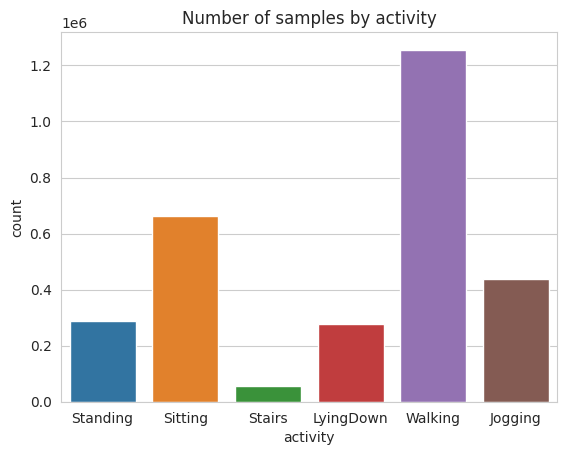

In [ ]:
# Plot activity counts
sns.set_style('whitegrid')
sns.countplot(x='activity', data=df)
plt.title('Number of samples by activity')
plt.show()

In [13]:
activities = ['Standing', 'Sitting', 'Stairs', 'LyingDown', 'Walking', 'Jogging']

In [14]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

n_steps = 50
step = 10
n_features = 3
random_seed = 42

le = LabelEncoder()
le.fit(activities)

segments = []
labels = []

for i in range(0,  df.shape[0]- n_steps, step):

    xs = df['x-axis'].values[i: i + 50]
    ys = df['y-axis'].values[i: i + 50]
    zs = df['z-axis'].values[i: i + 50]

    label = stats.mode(df['activity'][i: i + 50])[0][0]
    segments.append([xs, ys, zs])

    # Encode the label using the label encoder
    encoded_label = le.transform([label])[0]
    labels.append(encoded_label)

In [15]:
# Reshape the segments which is (list of arrays) to a list
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, n_steps, n_features)
labels = to_categorical(np.asarray(labels), num_classes=len(activities))

In [16]:
reshaped_segments.shape

(298072, 50, 3)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(reshaped_segments, labels, test_size = 0.2, random_state = random_seed)

In [18]:
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_train.shape, y_test.shape, np.mean(X_test), np.std(X_test))

(X shape, y shape, every X's mean, every X's standard deviation)
(238457, 50, 3) (59615, 6) 132327420000000.0 inf


In [19]:
# Checking Orders
activities = ['Standing', 'Sitting', 'Stairs', 'LyingDown', 'Walking', 'Jogging']
le = LabelEncoder()
le.fit(activities)

# Printing the classes in the order they're being encoded
print("Order of classes:", le.classes_)

# Generate some labels
labels = ['Walking', 'Standing', 'Sitting', 'Walking', 'Jogging']
encoded_labels = le.transform(labels)

# Print encoded labels
print("Encoded labels:", encoded_labels)

# Print decoded labels
decoded_labels = le.inverse_transform(encoded_labels)
print("Decoded labels:", decoded_labels)


Order of classes: ['Jogging' 'LyingDown' 'Sitting' 'Stairs' 'Standing' 'Walking']
Encoded labels: [5 4 2 5 0]
Decoded labels: ['Walking' 'Standing' 'Sitting' 'Walking' 'Jogging']


In [20]:
# Correct class labels orders
activities = ['Jogging', 'LyingDown', 'Sitting', 'Stairs', 'Standing', 'Walking']

# Training Classification Model

**Building Model Architecture**

In [21]:
model_name = f'RecognitionModel.h5'

In [22]:
# LTSM Model Architecture
def LSTM_RNN(n_steps, n_input, n_hidden, n_output):

    # define model
    model = Sequential()

    # Adjust n_input to match the number of features in your input data
    model.add(LSTM(n_hidden, return_sequences=True, input_shape=(n_steps, n_input)))
    # model.add(LSTM(n_hidden, return_sequences=True, input_shape=(50, 3)))

    model.add(LSTM(n_hidden))

    model.add(Dense(n_output, activation='softmax'))

    return model

In [23]:
def classify(classifier, fused_features):
    predictions = classifier(fused_features)  # Get model predictions
    class_indices = predictions.argmax(dim=1)  # Get the index of the class with highest predicted probability
    return class_indices

**Helper Function**

In [24]:
def plot_metric(metric_name_1, metric_name_2, plot_name):
  # Get Metric values using metric names as identifiers
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  # Constructing a range object which will be used as time
  epochs = range(len(metric_value_1))

  # Plotting the Graph
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

  # Adding title to the plot
  plt.title(str(plot_name))

  # Adding legend to the plot
  plt.legend()

**LTSM Model Training Process**

In [25]:
training_data_count = len(X_train)
test_data_count = len(X_test)
n_input = len(X_train[0][0])
n_output = y_train.shape[1]

n_hidden = 34
n_classes = 6


training_iters = training_data_count *5  # Loop 5 times on the dataset, ie 5 epochs
batch_size = 512
display_iter = batch_size*8  # To show test set accuracy during training

In [ ]:
model = LSTM_RNN(n_steps, n_input, n_hidden, n_output)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50, 34)            5168      
                                                                 
 lstm_3 (LSTM)               (None, 34)                9384      
                                                                 
 dense_1 (Dense)             (None, 6)                 210       
                                                                 
Total params: 14,762
Trainable params: 14,762
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Training
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
model_training_history = model.fit(X_train, y_train, epochs = 300, batch_size = batch_size , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/300
373/373 [==============================] - 17s 17ms/step - loss: 0.7375 - accuracy: 0.7317 - val_loss: 0.5423 - val_accuracy: 0.7962
Epoch 2/300
373/373 [==============================] - 4s 10ms/step - loss: 0.4975 - accuracy: 0.8128 - val_loss: 0.4610 - val_accuracy: 0.8217
Epoch 3/300
373/373 [==============================] - 4s 10ms/step - loss: 0.4337 - accuracy: 0.8350 - val_loss: 0.4347 - val_accuracy: 0.8320
Epoch 4/300
373/373 [==============================] - 5s 13ms/step - loss: 0.3957 - accuracy: 0.8485 - val_loss: 0.3881 - val_accuracy: 0.8551
Epoch 5/300
373/373 [==============================] - 4s 11ms/step - loss: 0.3666 - accuracy: 0.8577 - val_loss: 0.3639 - val_accuracy: 0.8598
Epoch 6/300
373/373 [==============================] - 4s 10ms/step - loss: 0.3413 - accuracy: 0.8677 - val_loss: 0.3285 - val_accuracy: 0.8722
Epoch 7/300
373/373 [==============================] - 4s 10ms/step - loss: 0.3268 - accuracy: 0.8740 - val_loss: 0.3185 - val_accuracy

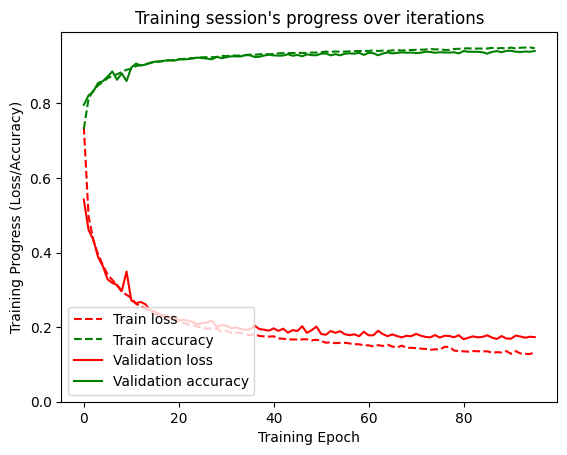

In [ ]:
# Plot Training session's progress over iterations
plt.plot(np.array(model_training_history.history['loss']), "r--", label = "Train loss")
plt.plot(np.array(model_training_history.history['accuracy']), "g--", label = "Train accuracy")
plt.plot(np.array(model_training_history.history['val_loss']), "r-", label = "Validation loss")
plt.plot(np.array(model_training_history.history['val_accuracy']), "g-", label = "Validation accuracy")
plt.title("Training session's progress over iterations")
plt.legend(loc='lower left')
plt.ylabel('Training Progress (Loss/Accuracy)')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.show()

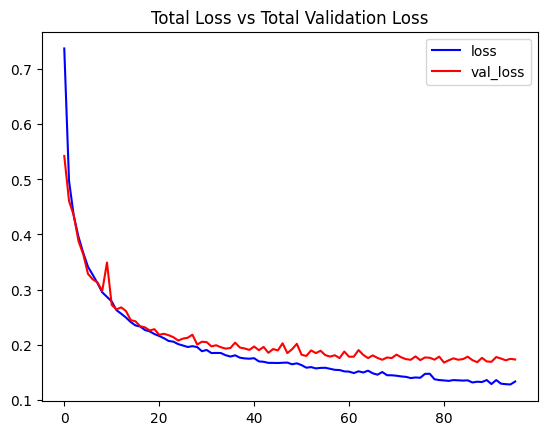

In [ ]:
# Plot Total Loss vs Total Validation Loss
plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss')

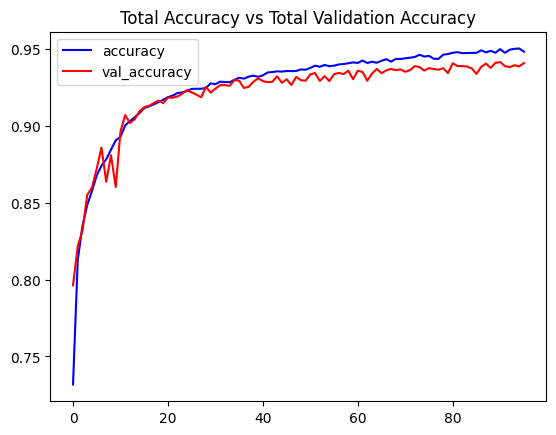

In [ ]:
# Plot Total Accuracy vs Total Validation Accuracy
plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

1863/1863 [==============================] - 12s 6ms/step


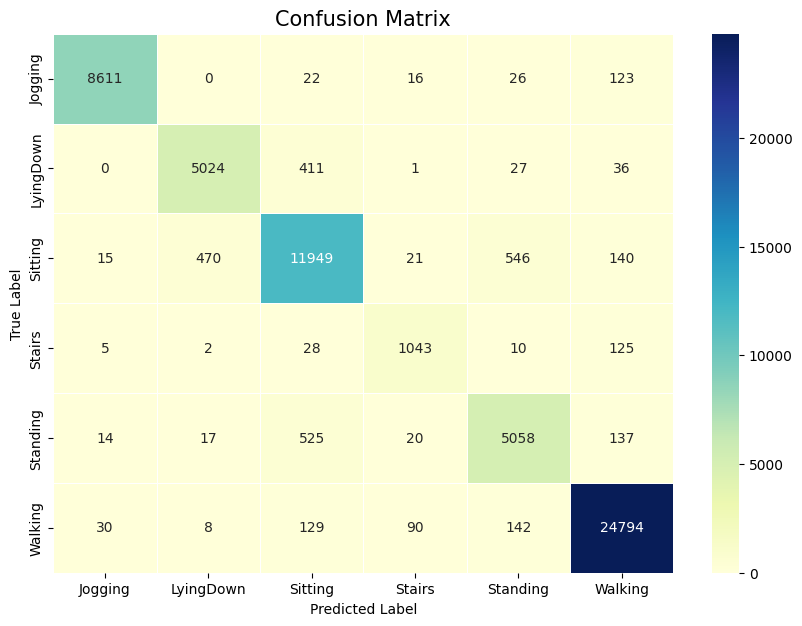

In [ ]:
# Plot Confusion Matrix
predictions = model.predict(X_test)
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)

plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix, xticklabels=activities, yticklabels=activities, annot=True, fmt='d', cmap='YlGnBu', linewidths=.5)
plt.title("Confusion Matrix", fontsize=15)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [ ]:
# Checking accuracy
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
multilabel_confusion_matrix(ytrue, yhat)
accuracy_score(ytrue, yhat)

1863/1863 [==============================] - 7s 4ms/step


0.9422964019122704

In [ ]:
# Saving your Model
model.save(model_name)

In [ ]:
# Delete current model
del model

# Conversion of Skeleton Poses to Joint-Limb Skeleton Heatmap
<h3>4. Conversion of Skeleton Poses to Joint-Limb Skeleton Heatmap</h3>
<p>The skeleton poses obtained from Movenet are then converted to joint-limb skeleton heatmaps.</p>
<ul>
<li><b>Input</b>: Skeleton poses</li>
<li><b>Action</b>: Conversion to joint-limb skeleton heatmap</li>
<li><b>Output</b>: Joint-limb skeleton heatmaps</li>
</ul>

Helper functions

In [26]:
# Function to convert skeleton poses to heatmap
def poses_to_heatmap(poses, size=(64, 64)):
    H, W = size

    # Define edges
    edges = [(0, 1), (0, 2), (1, 3), (2, 4), (0, 5), (0, 6), (5, 7), (7, 9),
             (6, 8), (8, 10), (5, 6), (5, 11), (6, 12), (11, 12), (11, 13),
             (13, 15), (12, 14), (14, 16)]

    heatmap = np.zeros((H, W), dtype=np.uint8)

    # draw the joints
    for pose in poses:
        x, y = int(pose[0]*W), int(pose[1]*H)
        x, y = min(x, W-1), min(y, H-1)  # Ensure the indices never exceed the size of the heatmap
        heatmap[y, x] = 255

    # draw the limbs
    for edge in edges:
        pt1 = poses[edge[0]]
        pt2 = poses[edge[1]]
        pt1 = (int(pt1[0]*W), int(pt1[1]*H))
        pt2 = (int(pt2[0]*W), int(pt2[1]*H))
        pt1 = (min(pt1[0], W-1), min(pt1[1], H-1))  # Ensure the indices never exceed the size of the heatmap
        pt2 = (min(pt2[0], W-1), min(pt2[1], H-1))  # Ensure the indices never exceed the size of the heatmap
        cv2.line(heatmap, pt1, pt2, 255, thickness=2)

    return heatmap

In [ ]:
# Convert skeleton poses to heatmaps
heatmaps_list = [poses_to_heatmap(pose, size=(64, 64)) for pose in reshaped_keypoints]

# Resize heatmaps to a consistent size
resized_heatmaps = []
desired_height = 64  # Desired height for the heatmaps
desired_width = 64  # Desired width for the heatmaps

for heatmap in heatmaps_list:
    heatmap_tensor = torch.from_numpy(heatmap).unsqueeze(0).unsqueeze(0).float()
    resized_heatmap = F.interpolate(heatmap_tensor, size=(desired_height, desired_width), mode='bilinear')
    resized_heatmaps.append(resized_heatmap.squeeze())

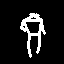

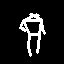

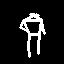

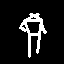

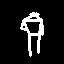

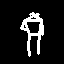

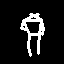

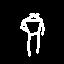

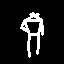

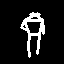

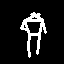

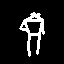

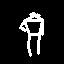

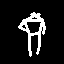

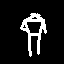

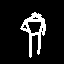

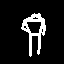

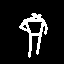

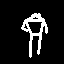

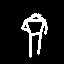

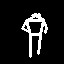

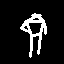

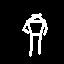

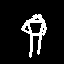

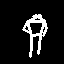

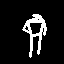

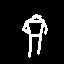

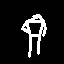

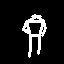

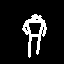

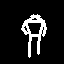

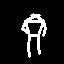

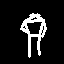

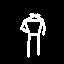

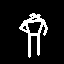

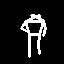

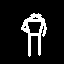

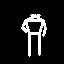

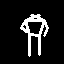

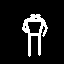

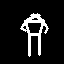

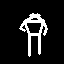

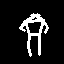

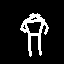

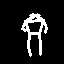

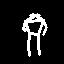

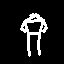

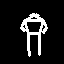

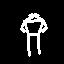

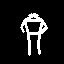

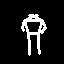

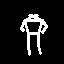

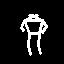

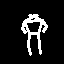

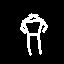

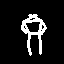

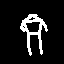

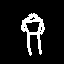

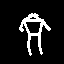

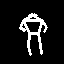

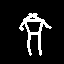

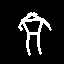

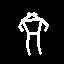

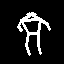

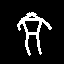

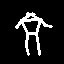

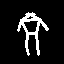

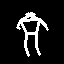

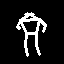

In [ ]:
# Displays Heatmap
for heatmap in heatmaps_list:
    cv2_imshow(heatmap)

# Feature Engineering
<h3>5. Feature Engineering</h3>
<p>The feature engineering stage consists of two streams - spatial and temporal feature extraction. The spatial stream operates on the ROI images and the temporal stream operates on the skeleton heatmaps. A Transformer encoder model is used in both streams with varying degrees of self-attention based on the frame rate.</p>

<h4>Spatial Feature Extraction Stream</h4>
<ul>
<li><b>Input</b>: ROI images</li>
<li><b>Action</b>: Apply Transformer encoder with fewer self-attention (lower frame rate)</li>
<li><b>Output</b>: Spatial features</li>
</ul>

<h4>Temporal Feature Extraction Stream</h4>
<ul>
<li><b>Input</b>: Joint-limb skeleton heatmaps</li>
<li><b>Action</b>: Apply Transformer encoder with more self-attention (higher frame rate)</li>
<li><b>Output</b>: Temporal features</li>
</ul>

In [ ]:
# Load Temporal Features
pickle_off = open('spatial_features.txt', 'rb')
spatial_features = pickle.load(pickle_off)

In [ ]:
# Load Temporal Features
pickle_off = open('temporal_features.txt', 'rb')
temporal_features = pickle.load(pickle_off)

In [27]:
# Function to extract spatial features
def extract_spatial_features(spatial_model, roi_images):
    # Ensure ROI images are tensor of shape [batch_size, num_channels, height, width]
    outputs = spatial_model(roi_images)
    spatial_features = outputs.pooler_output
    return spatial_features

# Function to extract temporal features
def extract_temporal_features(temporal_model, heatmaps):
    # Ensure heatmaps are tensor of shape [sequence_length, num_channels, height, width]
    outputs = temporal_model(heatmaps)
    temporal_features = outputs.pooler_output
    return temporal_features

In [ ]:
# Configure the spatial model
spatial_config = ViTConfig(
    image_size=64,
    patch_size=16,
    num_channels=1,
    num_attention_heads=4,  # fewer attention heads for spatial model
    num_hidden_layers= n_hidden,
    num_labels=1,
)

In [ ]:
# Configure the temporal model
temporal_config = ViTConfig(
    image_size=64,
    patch_size=16,
    num_channels=1,
    num_attention_heads=16,  # more attention heads for temporal model
    num_hidden_layers= n_hidden,
    num_labels=1,
)

# Spatial Feature Extraction Stream

In [ ]:
spatial_model = ViTModel(spatial_config)

In [ ]:
# Convert ROI frames to grayscale before resizing
gray_roi_frames = [cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) for frame in roi_frames]

# Resize grayscale ROI frames to a consistent size
resized_roi_frames = []
desired_height = 64  # Desired height for the frames
desired_width = 64  # Desired width for the frames
for frame in gray_roi_frames:
    frame_tensor = torch.from_numpy(frame).unsqueeze(0).unsqueeze(0).float()  # Add two dimensions for batch and channel
    resized_frame = F.interpolate(frame_tensor, size=(desired_height, desired_width), mode='bilinear')
    resized_roi_frames.append(resized_frame.squeeze())

# Stack the grayscale ROI frames
roi_images = torch.stack(resized_roi_frames)

# Add an extra channel dimension to roi_images
roi_images = roi_images.unsqueeze(1)

# Extract spatial features
spatial_features = extract_spatial_features(spatial_model, roi_images)

# Print the dimensions of the outputs
print(spatial_features.shape)

torch.Size([69, 768])


In [ ]:
# Displays grayscale ROI frames
for gray_roi_frame in gray_roi_frames:
    cv2_imshow(gray_roi_frame)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print(len(spatial_features))

69


In [ ]:
# Save Spatial Features
with open('spatial_features.txt','wb') as f1:
  pickle.dump(spatial_features, f1)

# Temporal Feature Extraction Stream

In [ ]:
temporal_model = ViTModel(temporal_config)

In [ ]:
# Stack the resized heatmaps
heatmaps = torch.stack(resized_heatmaps)

# Add an extra channel dimension to pixel_values
heatmaps = heatmaps.unsqueeze(1)

temporal_features = extract_temporal_features(temporal_model, heatmaps)
print(temporal_features.shape)

torch.Size([69, 768])


In [ ]:
print(len(temporal_features))

69


In [ ]:
# Save Temporal Features
with open('temporal_features.txt','wb') as f1:
  pickle.dump(temporal_features, f1)

In [ ]:
print(f'Length of frames: {len(frames)}')
print(f'Length of ROI frames: {len(roi_frames)}')
print(f'Length of skeleton poses: {len(skeleton_poses)}')
print(f'Length of temporal features: {len(temporal_features)}')
print(f'Length of spatial features: {len(spatial_features)}')

Length of frames: 69
Length of ROI frames: 69
Length of skeleton poses: 69
Length of temporal features: 69
Length of spatial features: 69


# Fusion of Spatial and Temporal Features
<h3>6. Fusion of Spatial and Temporal Features</h3>
<p>The extracted spatial and temporal features are then fused together. This can be done either as an early fusion (before encoding and classification) or as a late fusion (after separate encoding and classification).</p>
<ul>
<li><b>Input</b>: Spatial features, Temporal features</li>
<li><b>Action</b>:
<ul>
<li>Early Fusion: Combine features before encoding and classification</li>
<li>Late Fusion: Encode features separately, generate individual classifications, and then fuse for final decision</li>
</ul>
</li>
<li><b>Output</b>: Combined features</li>
</ul>

In [28]:
def fuse_features(spatial_features, temporal_features, n_classes):
    # Add a dimension at index 1 if it doesn't exist
    if spatial_features.dim() < 2:
        spatial_features = spatial_features.unsqueeze(1)
    if temporal_features.dim() < 2:
        temporal_features = temporal_features.unsqueeze(1)

    # Early Fusion: Combine features before encoding and classification
    early_fused_features = torch.cat((spatial_features, temporal_features), dim=1)

    # Late Fusion: Encode features separately, generate individual classifications, then fuse for final decision
    spatial_feature_size = spatial_features.shape[1]
    temporal_feature_size = temporal_features.shape[1]
    classifier_input_size = spatial_feature_size + temporal_feature_size
    classifier = nn.Linear(classifier_input_size, n_classes)

    late_fused_features = torch.cat((spatial_features, temporal_features), dim=1)

    return early_fused_features, late_fused_features

In [ ]:
# Process Early and Late fused features
early_fused_features, late_fused_features = fuse_features(spatial_features, temporal_features, n_classes)

# Combined Early and Late
combined_features = torch.cat((early_fused_features, late_fused_features), dim=1)

print("Shape of spatial features: ", spatial_features.shape)
print("Shape of temporal features: ", temporal_features.shape)
print("Shape of combined_features: ", combined_features.shape)

Shape of spatial features:  torch.Size([69, 768])
Shape of temporal features:  torch.Size([69, 768])
Shape of combined_features:  torch.Size([69, 3072])


# Classification Models
<h3>7. Classification Model</h3>
<p>The final step of the pipeline involves using a classification model to predict the activity class based on the combined features.</p>
<ul>
<li><b>Input</b>: Combined features</li>
<li><b>Action</b>: Classification using a suitable model</li>
<li><b>Output</b>: Activity class</li>
</ul>

In [ ]:
# Reshape to the correct size
# Initialize PCA with 3 components
pca = PCA(n_components=3)

# Flatten the features for PCA
flattened_features = combined_features.reshape(-1, combined_features.shape[-1])

# Apply PCA to the features
transformed_features = pca.fit_transform(flattened_features.detach().numpy())

# Create an array of zeros with desired shape
combined_features = np.zeros((1, 50, 3))

# Determine the number of sequences to copy
num_sequences = min(50, transformed_features.shape[0])

# Copy the sequences
combined_features[0, :num_sequences] = transformed_features[:num_sequences]

print("Shape of flattened_features: ", flattened_features.shape)
print("Shape of transformed_features: ", transformed_features.shape)
print("Shape of combined_features: ", combined_features.shape)

Shape of flattened_features:  torch.Size([69, 3072])
Shape of transformed_features:  (69, 3)
Shape of combined_features:  (1, 50, 3)


In [ ]:
# Load Model
model = LSTM_RNN(n_steps, n_input, n_hidden, n_output)
model.load_weights(model_name)

In [ ]:
final = "/content/drive/MyDrive/ActivityRecognition/final"
if not os.path.exists(final):
    os.makedirs(final)

In [ ]:
# Processing all at once seems to be accurately dected
# Ensure correct shape
if combined_features.shape != (50, 3):
    combined_features = combined_features.reshape(50, 3)

# Add batch_size dimension
combined_features = np.expand_dims(combined_features, axis=0)

# Get logits
logits = model(combined_features)

# Calculate probabilities
probabilities = tf.nn.softmax(logits, axis=1)

# Get predicted classes
predicted_classes = tf.argmax(probabilities, axis=1)

# Define activity order
activities = ['Jogging', 'LyingDown', 'Sitting', 'Stairs', 'Standing', 'Walking']

# Get class names
predicted_class_names = [activities[i] for i in tf.keras.backend.get_value(predicted_classes)]

# Print results
print("Logits:", tf.keras.backend.get_value(logits))
print("Probabilities:", tf.keras.backend.get_value(probabilities))
print("Predicted class indices:", tf.keras.backend.get_value(predicted_classes))
print("Predicted class names:", predicted_class_names)


Logits: [[   0.020128  9.3368e-05   0.0064069      0.9732  8.1602e-05  8.7233e-05]]
Probabilities: [[    0.13297     0.13033     0.13116     0.34488     0.13033     0.13033]]
Predicted class indices: [3]
Predicted class names: ['Stairs']


In [ ]:
final_output = []
predicted_class_name = predicted_class_names[0]
for i, poses_on_frame in enumerate(poses_on_frames):
    image = cv2.putText(poses_on_frame, predicted_class_name, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)
    final_output.append(image)
    cv2.imwrite(os.path.join(final, f'final{i}.jpg'), poses_on_frame)
    cv2_imshow(poses_on_frame)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print(len(final_output))

69


In [ ]:
to_mp4(final_output, '#final.mp4')

# Applying Sequences for better recognition

In [29]:
# LTSM Model Architecture
def LSTM_RNN(n_steps, n_input, n_hidden, n_output):

    # define model
    model = Sequential()

    # Adjust n_input to match the number of features in your input data
    model.add(LSTM(n_hidden, return_sequences=True, input_shape=(n_steps, n_input)))
    # model.add(LSTM(n_hidden, return_sequences=True, input_shape=(50, 3)))

    model.add(LSTM(n_hidden))

    model.add(Dense(n_output, activation='softmax'))

    return model

# Configure the temporal model
temporal_config = ViTConfig(
    image_size=64,
    patch_size=16,
    num_channels=1,
    num_attention_heads=16,  # more attention heads for temporal model
    num_hidden_layers= n_hidden,
    num_labels=1,
)

# Configure the spatial model
spatial_config = ViTConfig(
    image_size=64,
    patch_size=16,
    num_channels=1,
    num_attention_heads=4,  # fewer attention heads for spatial model
    num_hidden_layers= n_hidden,
    num_labels=1,
)

In [30]:
# Load models
yolo_model = YOLO('yolov8x.pt')

model = LSTM_RNN(n_steps, n_input, n_hidden, n_output)
model_name = f'RecognitionModel.h5'
model.load_weights(model_name)

temporal_model = ViTModel(temporal_config)

spatial_model = ViTModel(spatial_config)

In [31]:
# Create and Define Saving Folders
frames_save_path = "/content/drive/MyDrive/ActivityRecognition/frames"
if not os.path.exists(frames_save_path):
    os.makedirs(frames_save_path)

rois_save_path = '/content/drive/MyDrive/ActivityRecognition/rois'
if not os.path.exists(rois_save_path):
    os.makedirs(rois_save_path)

skeleton_save_path = '/content/drive/MyDrive/ActivityRecognition/poses_on_frame'
if not os.path.exists(skeleton_save_path):
    os.makedirs(skeleton_save_path)

skeleton_poses_save_path = '/content/drive/MyDrive/ActivityRecognition/skeleton_poses'
if not os.path.exists(skeleton_poses_save_path):
    os.makedirs(skeleton_poses_save_path)

final = "/content/drive/MyDrive/ActivityRecognition/final"
if not os.path.exists(final):
    os.makedirs(final)

In [32]:
SEQUENCE_LENGTH = 8

In [33]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    frames_generator = extract_frames(video_file_path, frames_save_path)

    output_frames = []
    roi_frames = []
    skeleton_poses = []
    reshaped_keypoints = []
    poses_on_frames = []

    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    predicted_class_name = ''

    frame_counter = 0
    for i, frame in enumerate(frames_generator):
        frames_queue.append(frame)

        if len(frames_queue) == SEQUENCE_LENGTH:
            frames_list = list(frames_queue)

            # Detect and Track
            tracked_frames_and_rois = detect_and_track(frames_list, yolo_model, rois_save_path, skeleton_save_path, skeleton_poses_save_path)

            for processed_frame, roi, skeleton_pose, reshaped_keypoint, poses_on_frame in tracked_frames_and_rois:
                if roi is not None:
                    roi_frames.append(roi)
                if skeleton_pose is not None:
                    skeleton_poses.append(skeleton_pose)
                if reshaped_keypoint is not None:
                    reshaped_keypoints.append(reshaped_keypoint)
                if poses_on_frame is not None:
                    poses_on_frames.append(poses_on_frame)

            # Convert skeleton poses to heatmaps
            heatmaps_list = [poses_to_heatmap(pose, size=(64, 64)) for pose in reshaped_keypoints]

            # Resize heatmaps to a consistent size
            resized_heatmaps = []
            desired_height = 64  # Desired height for the heatmaps
            desired_width = 64  # Desired width for the heatmaps

            for heatmap in heatmaps_list:
                heatmap_tensor = torch.from_numpy(heatmap).unsqueeze(0).unsqueeze(0).float()
                resized_heatmap = F.interpolate(heatmap_tensor, size=(desired_height, desired_width), mode='bilinear')
                resized_heatmaps.append(resized_heatmap.squeeze())

            # Stack the resized heatmaps
            heatmaps = torch.stack(resized_heatmaps)

            # Add an extra channel dimension to pixel_values
            heatmaps = heatmaps.unsqueeze(1)

            temporal_features = extract_temporal_features(temporal_model, heatmaps)
            print(temporal_features.shape)

            # Convert ROI frames to grayscale before resizing
            gray_roi_frames = [cv2.cvtColor(roi_frame, cv2.COLOR_BGR2GRAY) for roi_frame in roi_frames]

            # Resize grayscale ROI frames to a consistent size
            resized_roi_frames = []
            desired_height = 64  # Desired height for the frames
            desired_width = 64  # Desired width for the frames
            for aframe in gray_roi_frames:
                frame_tensor = torch.from_numpy(aframe).unsqueeze(0).unsqueeze(0).float()  # Add two dimensions for batch and channel
                resized_frame = F.interpolate(frame_tensor, size=(desired_height, desired_width), mode='bilinear')
                resized_roi_frames.append(resized_frame.squeeze())

            # Stack the grayscale ROI frames
            roi_images = torch.stack(resized_roi_frames)

            # Add an extra channel dimension to roi_images
            roi_images = roi_images.unsqueeze(1)

            # Extract spatial features
            spatial_features = extract_spatial_features(spatial_model, roi_images)
            print(spatial_features.shape)

            # Process Early and Late fused features
            early_fused_features, late_fused_features = fuse_features(spatial_features, temporal_features, n_classes)

            # Combined Early and Late
            combined_features = torch.cat((early_fused_features, late_fused_features), dim=1)

            print("Shape of spatial features: ", spatial_features.shape)
            print("Shape of temporal features: ", temporal_features.shape)
            print("Shape of combined_features: ", combined_features.shape)

            # Force Reshape to the correct size if the above function shows error
            # Initialize PCA with 3 components
            pca = PCA(n_components=3)

            # Flatten the features for PCA
            flattened_features = combined_features.reshape(-1, combined_features.shape[-1])

            # Apply PCA to the features
            transformed_features = pca.fit_transform(flattened_features.detach().numpy())

            # Create an array of zeros with desired shape
            combined_features = np.zeros((1, 50, 3))

            # Determine the number of sequences to copy
            num_sequences = min(50, transformed_features.shape[0])

            # Copy the sequences
            combined_features[0, :num_sequences] = transformed_features[:num_sequences]

            print("Shape of flattened_features: ", flattened_features.shape)
            print("Shape of transformed_features: ", transformed_features.shape)
            print("Shape of combined_features: ", combined_features.shape)


            # Processing all at once seems to be accurately dected
            # Ensure correct shape
            if combined_features.shape != (50, 3):
                combined_features = combined_features.reshape(50, 3)

            # Add batch_size dimension
            combined_features = np.expand_dims(combined_features, axis=0)

            # Get logits
            logits = model(combined_features)

            # Calculate probabilities
            probabilities = tf.nn.softmax(logits, axis=1)

            # Get predicted classes
            predicted_classes = tf.argmax(probabilities, axis=1)

            # Define activity order
            activities = ['Jogging', 'LyingDown', 'Sitting', 'Stairs', 'Standing', 'Walking']

            # Get class names
            predicted_class_names = [activities[i] for i in tf.keras.backend.get_value(predicted_classes)]

            # Print results
            print("Logits:", tf.keras.backend.get_value(logits))
            print("Probabilities:", tf.keras.backend.get_value(probabilities))
            print("Predicted class indices:", tf.keras.backend.get_value(predicted_classes))
            print("Predicted class names:", predicted_class_names)

            predicted_class_name = predicted_class_names[0]
            # Draw the predicted class name on the frame
            cv2.putText(frame, predicted_class_name, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)
            output_frames.append(frame)

            # cv2.imwrite(os.path.join(final, f'final{frame_counter}.jpg'), frame)
            cv2_imshow(frame)


    # to_mp4(output_frames, save_path)


In [34]:
video_path = '/content/drive/MyDrive/ActivityRecognition/video/TEST_IRL2_SHORT.mp4'
save_path = 'final.mp4'

In [ ]:
predict_on_video(video_path, save_path, SEQUENCE_LENGTH)

Output hidden; open in https://colab.research.google.com to view.

Even though the preocess is unable to complete as there are some limitation on Google Colab, but the use of sequence for activity recognition is significantly advantageous, mainly because it considers the temporal relationships between consecutive frames, which plays a crucial role in accurately recognizing actions or activities. When recognizing an activity in a video, each frame isn't independent but is part of a sequence that together forms the whole activity. By processing a sequence of frames together, the model can identify patterns across time, which often provide essential context for distinguishing between different activities.

For example, both "jogging" and "walking" involve similar movements of the arms and legs. However, the sequence, speed, and rhythm of these movements differ between the two activities. By analyzing a sequence of frames, a model can capture these differences and correctly identify the activity. So, in essence, applying SEQUENCE brings in the aspect of temporal dynamics into the model's analysis, enabling it to discern patterns in motion over time, thereby leading to more accurate activity recognition.